# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, roc_curve, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import GridSearchCV
from yellowbrick.features import rank2d, rank1d
import statsmodels.api as sm
from statsmodels.tools import add_constant
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier



%matplotlib inline
plt.style.use('seaborn-white')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Load Data

In [ ]:
weather = pd.read_csv("/content/drive/MyDrive/WeatherData20years.csv")

elp1 = pd.read_excel("/content/drive/MyDrive/CDOTRM_CD_Crash_Listing_-_2015.xlsx", parse_dates=[['date','time']])
elp2 = pd.read_excel("/content/drive/MyDrive/CDOTRM_CD_Crash_Listing_-_2016.xlsx",parse_dates=[['date','time']])
elp3 = pd.read_excel("/content/drive/MyDrive/CDOTRM_CD_Crash_Listing_-_2017.xlsx",parse_dates=[['date','time']])
elp4 = pd.read_excel("/content/drive/MyDrive/CDOTRM_CD_Crash_Listing_-_2018.xlsx",parse_dates=[['date','time']])
elp5 = pd.read_excel("/content/drive/MyDrive/CDOTRM_CD_Crash_Listing_-_2019.xlsx",parse_dates=[['date','time']])

#Crash Data Cleaning

In [ ]:
#merge into single df and filter for relevant county... El Paso 
elp1 = elp1.append(elp2)
elp1 = elp1.append(elp3)
elp1 = elp1.append(elp4)
elp1 = elp1.append(elp5)

crash = elp1[elp1['county'] == 'EL PASO']
crash = crash.reset_index(drop = True)

#full list of features for reference

#link to data dictionary - 
#         https://www.codot.gov/safety/traffic-safety/safety-programs-data/crash-data

#['system,rte,sec	mp,date	time,	severity,	injlevel_1,	injlevel_2,	injlevel_3,	injlevel_4,	injlevel_5,	
#agencyname,	location,	road_desc	vehicles,	contour	condition,	lighting,	weather,	limit1,	limit2,	limit3,
#ramp,	region,	rucode,	event_1,	event_2,	event_3,	mhe,	acctype	dir_1,	vehicle_1,	driver_1,	factor_1,	speed_1,	veh_move_1,	age_1,
#state_1,	belt_1,	dir_2,	vehicle_2,	driver_2,	factor_2,	speed_2,	veh_move_2,	age_2,	state_2,	belt_2,	dir_3,	vehicle_3,
#driver_3,	factor_3,	speed_3,	veh_move_3,	age_3,	state_3,	belt_3,	wan_type,	loc_01,	link,	loc_02,	hazmat_1,	hazmat_2,	hazmat_3,	violcode_1,
#violcode_2,	violcode_3,	cycprot_1,	cycprot_2,	cycprot_3,	drvinj_1,	drvinj_2,	drvinj_3,	dui_1,	dui_2,	dui_3,	city,	county,	latitude,	longitude']

#clean for relevant info
crash = crash[['date_time','loc_01']]
crash = crash.dropna()

def hour_rounder(t):
    # Rounds down to the nearest half hour
    new_minute = (t.minute // 30) * 30
    return  t + timedelta(minutes=new_minute - t.minute)

crash['date_time'] = crash['date_time'].apply(hour_rounder)
EDAcrash = crash.copy()
crash = crash.set_index("date_time")

#binary severity class indicator
  #If 0 then no accident. If 1, then there was an accident
crash['Crash Severity'] = 1

#There is an option here to create additional severity classes.
  #ex. 0 if no crash,  1 if crash but none injured, 2 if somone was injured, 3 if someone died
  #due to so few records of injuries and death, this model only used classes 0 and 1

# Weather Data Cleaning

In [ ]:
#link to data dictionary
#       https://openweathermap.org/api/history-api-timestamp

weather = weather.drop(['dt','timezone','city_name','lat','lon','weather_id','weather_icon','sea_level','grnd_level',
                        'rain_3h','snow_3h','weather_main'], axis =1)

#High Colinearity with these features and "temp" which we kept 
weather = weather.drop(['feels_like','temp_min','temp_max'], axis = 1)

#clean up the time to merge with traffic data
#get time in correct format
weather['dt_iso'] = weather['dt_iso'].str.split('+').str.get(0)
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'])

#only years that correspond with traffic accidents
years = [2015,2016,2017,2018,2019] #years for El Paso county
weather = weather[weather['dt_iso'].dt.year.isin(years)]
EDAweather = weather.copy()
weather = weather.set_index("dt_iso")
#weather.head()


#Convert temp from Kelvin to F for readability
weather['temp'] = (weather['temp'] - 273.15) * 9/5 + 32

## Add Half hour increments to weather


Weather API only allows for hourly pulls. This has created an imbalance in our data set, where we have lots of hours that pair with accidents, and few that dont. To remedy this and balance the data set, we will pair weather and crashes on the half hour. The values in these half hour increments will consists of the average of the values from the previous hour and the next hour

values at index n = (n -1, n+1)/2

In [ ]:
weather = weather.reset_index()
weatherhalf = weather.copy()
weatherhalf['dt_iso'] = weatherhalf['dt_iso'] + pd.Timedelta(minutes=30)
weather = weather.append(weatherhalf)
weather = weather.set_index("dt_iso")
weather = weather.sort_index()
#find average values on either side in future iterations

## Encoding

### Label Encoder

In [ ]:
le = preprocessing.LabelEncoder()
weather['weather_description'] = le.fit_transform(weather['weather_description'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
weatherlabel = pd.Series(le_name_mapping, name='Weather Label')
print(weatherlabel)

broken clouds                    0
drizzle                          1
dust                             2
extreme rain                     3
few clouds                       4
fog                              5
haze                             6
heavy intensity drizzle          7
heavy intensity rain             8
heavy intensity shower rain      9
heavy shower snow               10
heavy snow                      11
light intensity drizzle         12
light intensity shower rain     13
light rain                      14
light rain and snow             15
light shower sleet              16
light shower snow               17
light snow                      18
mist                            19
moderate rain                   20
overcast clouds                 21
proximity thunderstorm          22
ragged thunderstorm             23
scattered clouds                24
shower rain                     25
shower sleet                    26
shower snow                     27
sky is clear        

### OneHot


In [ ]:

#dum_df = pd.get_dummies(weather,columns = ['weather_description'])
#fill NaN values with zero
#dum_df = dum_df.fillna(value = 0)

#some weather values had multiple weather descriptions for the same hour. To handle I created dummies for each weather 
#description, grouped by their datetime, and averaged the dummy variables. So if it is snowing and hailing @1pm,
#there will be .5 in the snow column and .5 in the weather column.
#dum_df = dum_df.groupby( by = dum_df.index).mean()
#weather = dum_df

##Introduced some demintionality issues

# Merge Crash Weather

In [ ]:
#merge weather and crash data
crashweather = weather.join(crash, how = 'outer')

#weather without a corresponding crash data point have nulls in the crash severity. Fill w/0 for the 'No accident' class
crashweather = crashweather.fillna(value = 0)
#crashweather.info()


#reset index to street name, drop time/date

crashweather = crashweather.set_index('loc_01',append=True)

#dropping highly correlated values (based on Pearson heatmap)
#crashweather = crashweather.drop('weather_description_sky is clear', axis = 1) # if using onehot





# Exploratory Data Analysis


## Crash Severity Class Distribution

Text(0.5, 0, 'Severity Class')

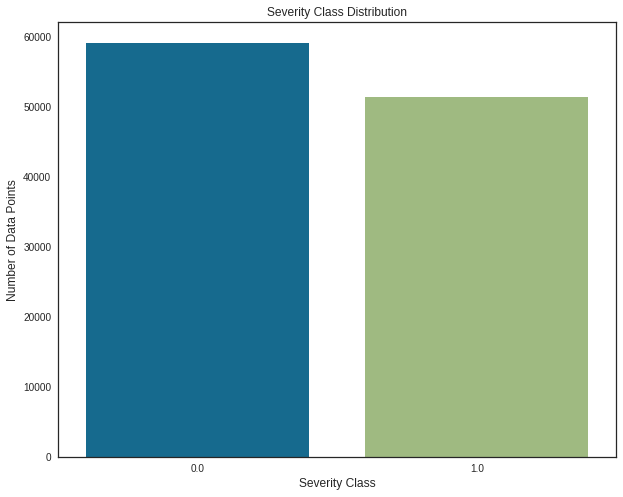

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.countplot(data = crashweather, x = "Crash Severity")
plt.title("Severity Class Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('Severity Class', fontsize=12)

## Crash Timeline

#### Yearly Crash Distribution


Text(0.5, 0, 'Year')

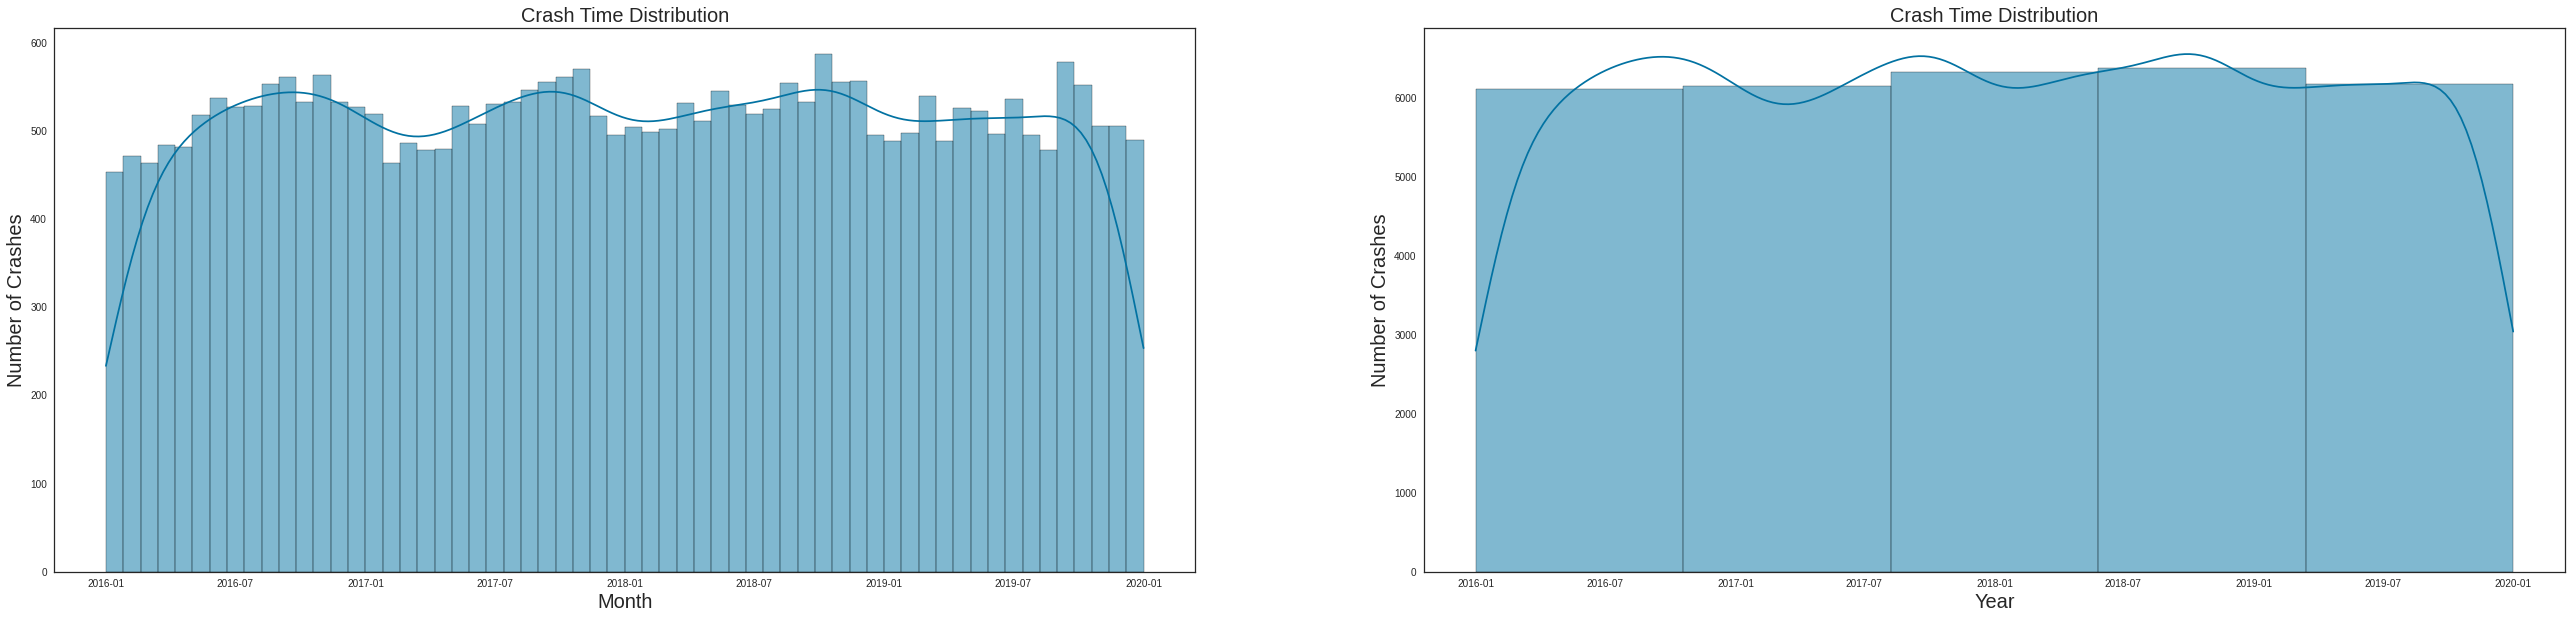

In [ ]:
#visualizing timeline of accidents recroded by month
f, axs = plt.subplots(2,2,figsize=(45,10))


timeline = EDAcrash.groupby('date_time').count().reset_index()

plt.subplot(1,2,1)
axs = sns.histplot(data = timeline, x = "date_time", kde = True, bins = 60)
#bin = 60 is hardcoded # of months in the crash data set (5 years)
plt.title("Crash Time Distribution",fontsize=20)
plt.ylabel('Number of Crashes', fontsize=20)
plt.xlabel('Month', fontsize=20)

plt.subplot(1,2,2)
axs = sns.histplot(data = timeline, x = "date_time", kde = True, bins = 5)
#bin = 60 is hardcoded # of months in the crash data set (5 years)
plt.title("Crash Time Distribution",fontsize=20)
plt.ylabel('Number of Crashes', fontsize=20)
plt.xlabel('Year', fontsize=20)

#### Hourly Crash Distribution

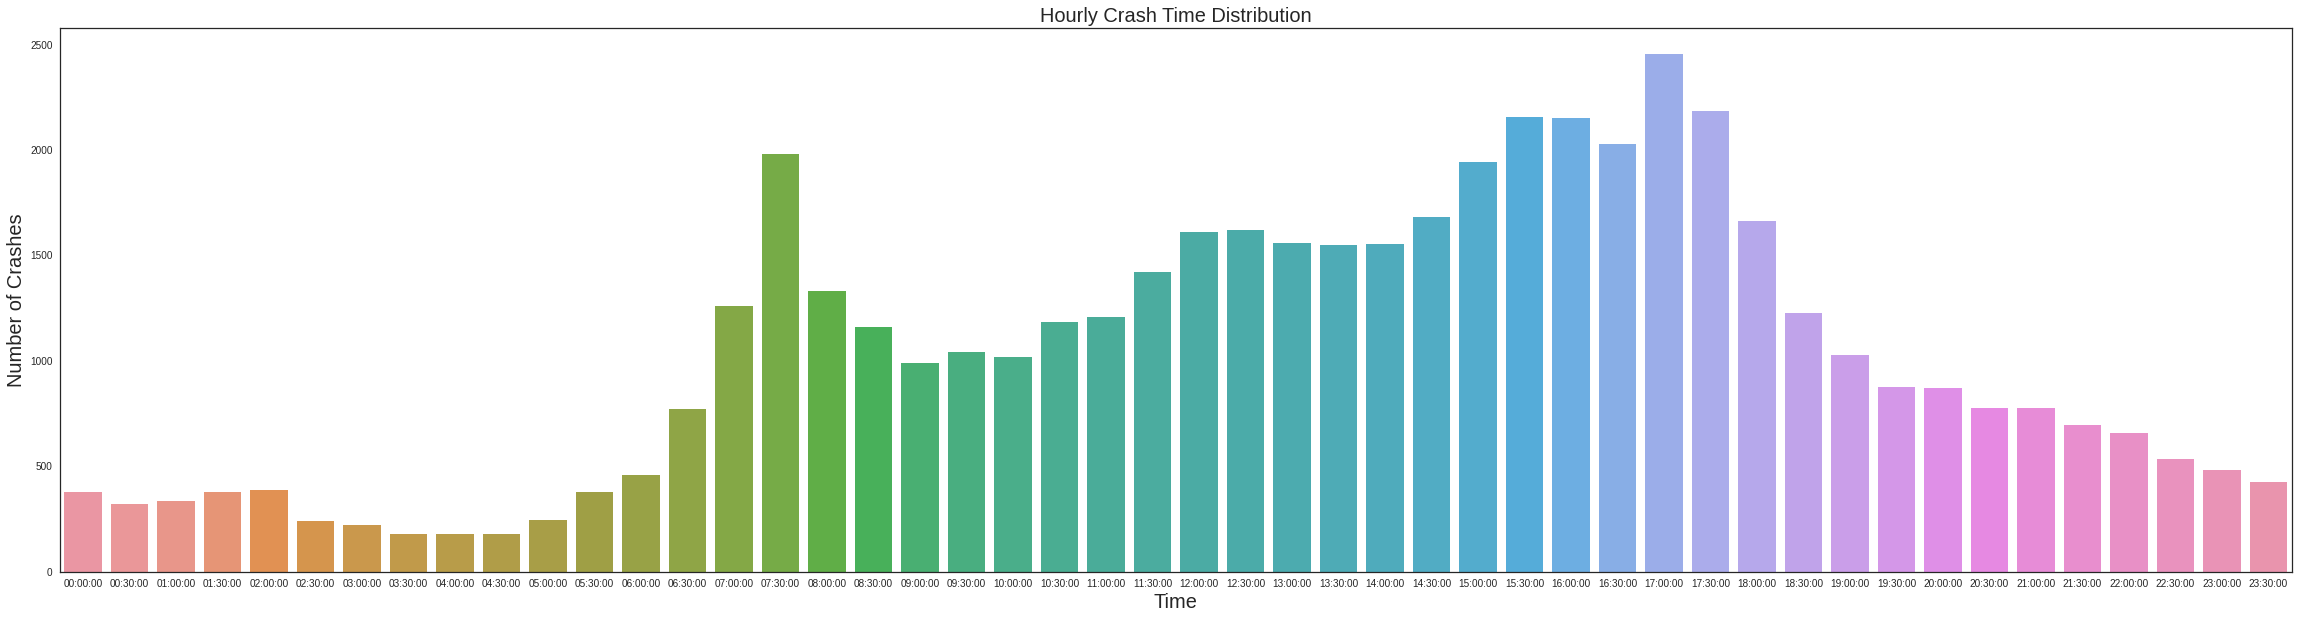

In [ ]:
#groupby half hour increments 
hourly = EDAcrash.groupby(EDAcrash.date_time.dt.time).count()
hourly = hourly['loc_01'] 
hourly = hourly.reset_index()


plt.figure(figsize=(40,10))
axs = sns.barplot(x = 'date_time', y = 'loc_01', data = hourly)
plt.title("Hourly Crash Time Distribution",fontsize=20)
plt.ylabel('Number of Crashes', fontsize=20)
plt.xlabel('Time', fontsize=20)


plt.show()

#### Day of Week Crash Distribution


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



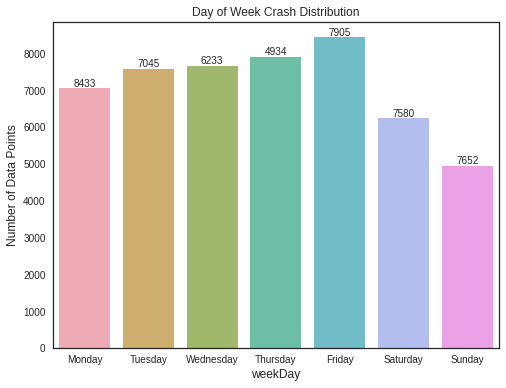

In [ ]:
daily = EDAcrash.copy()
daily['weekday'] = daily['date_time'].dt.day_name()

a = daily['weekday'].value_counts()
a = a.sort_index()

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(a.index, a.values, alpha=0.8,order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Day of Week Crash Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('weekDay', fontsize=12)

# adding the text labels
rects = ax.patches
labels = a.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### Seasonal Crash Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



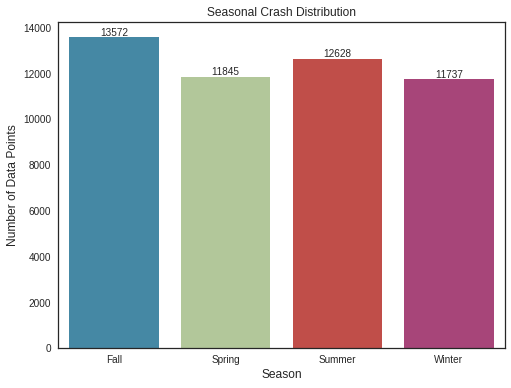

In [ ]:
season= EDAcrash.copy()
season['Season'] = season['date_time'].dt.month%12 // 3 + 1 #math operation to catagorize month into season

season.loc[season["Season"] == 1, 'Season'] = 'Winter'
season.loc[season["Season"] == 2, 'Season'] = 'Spring'
season.loc[season["Season"] == 3, 'Season'] = 'Summer'
season.loc[season["Season"] == 4, 'Season'] = 'Fall'

a = season['Season'].value_counts()
a = a.sort_index()

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(a.index, a.values, alpha=0.8)
plt.title("Seasonal Crash Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('Season', fontsize=12)

# adding the text labels
rects = ax.patches
labels = a.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


## Weather Distribution

### General Weather distribution

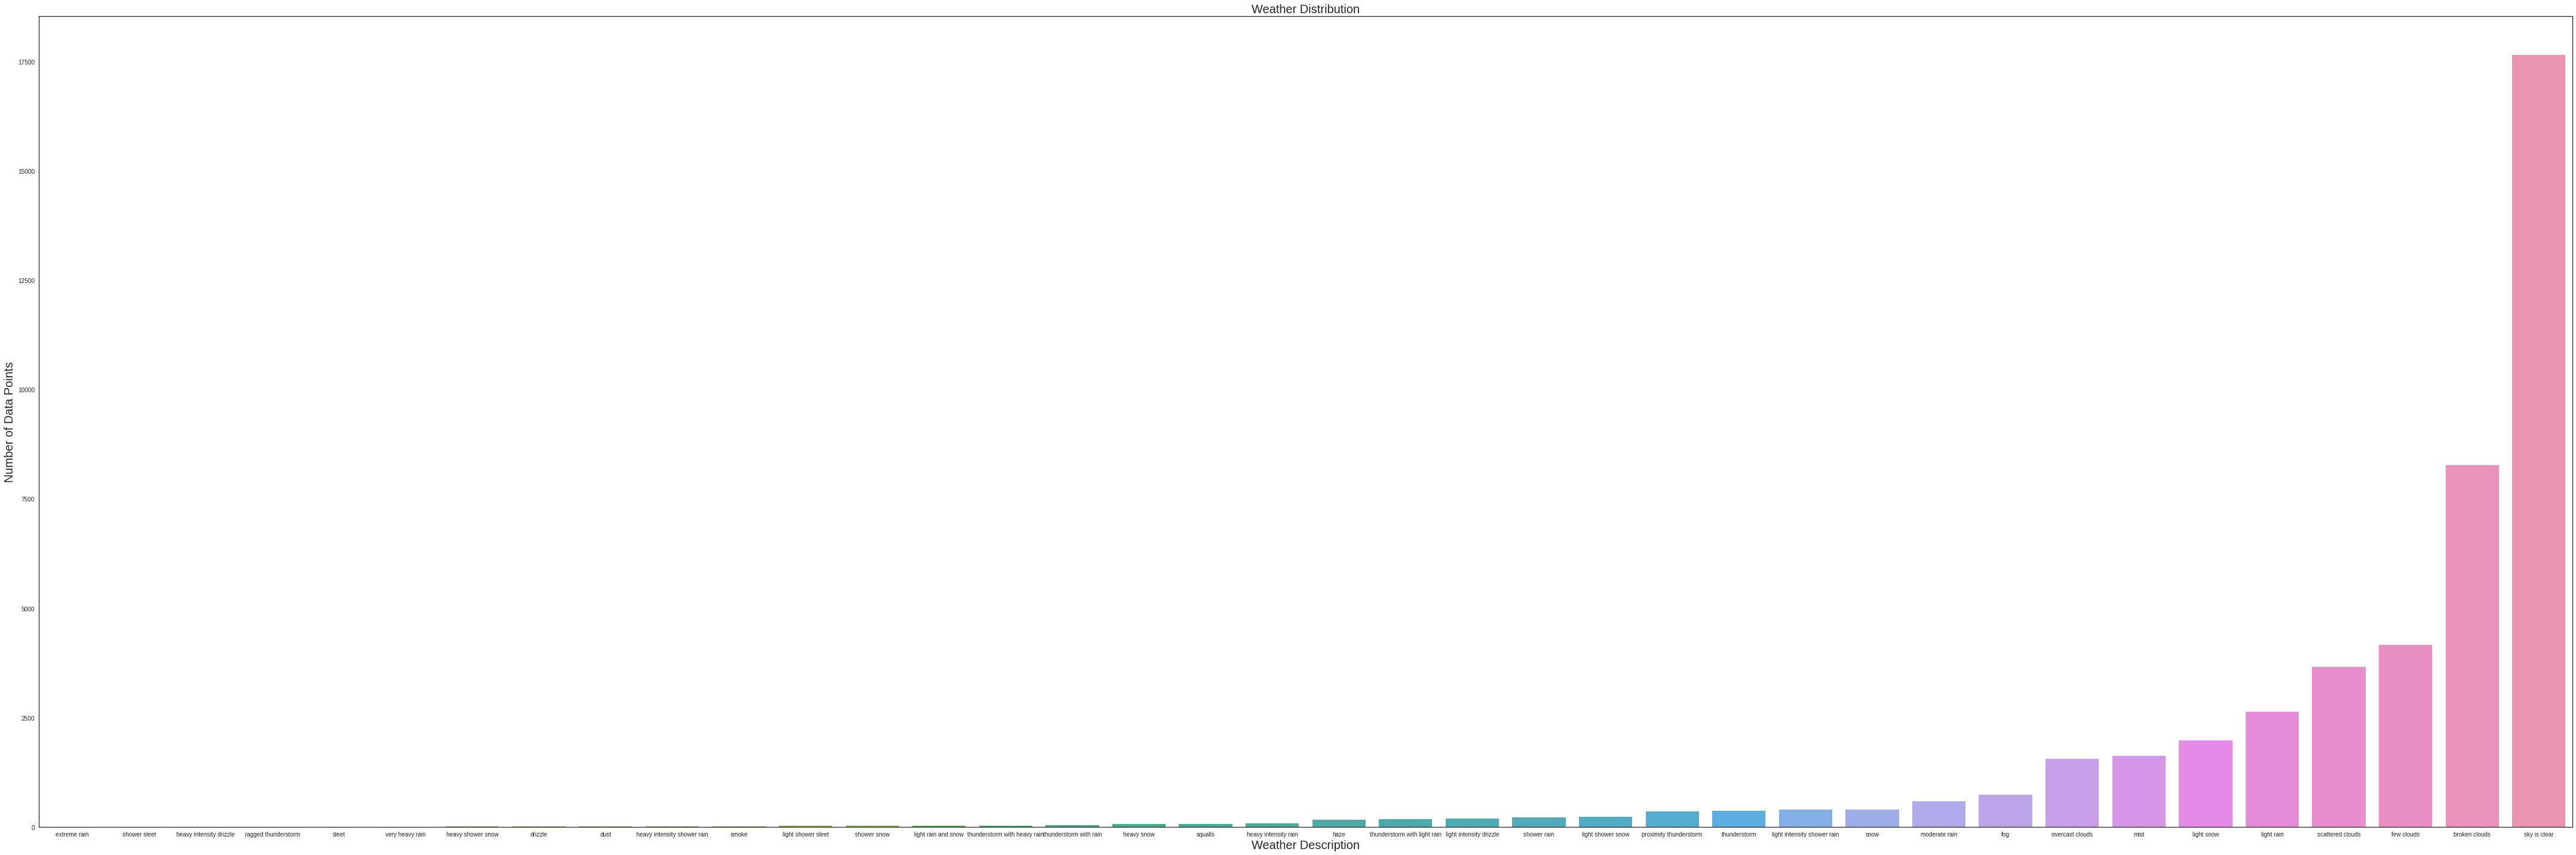

In [ ]:
weatherdist = EDAweather.groupby(EDAweather.weather_description).count()
weatherdist = weatherdist['dt_iso'] 
weatherdist = weatherdist.reset_index()


plt.figure(figsize=(60,20))
axs = sns.barplot(x = 'weather_description', y = 'dt_iso', data = weatherdist, order = weatherdist.sort_values('dt_iso').weather_description)
plt.title("Weather Distribution",fontsize=20)
plt.ylabel('Number of Data Points', fontsize=20)
plt.xlabel('Weather Description', fontsize=20)

plt.tight_layout()

### Weather Distribution in Crash Classes

In [ ]:
weatherhalf = EDAweather.copy()
weatherhalf['dt_iso'] = weatherhalf['dt_iso'] + pd.Timedelta(minutes=30)
EDAweather = EDAweather.append(weatherhalf)
EDAweather = EDAweather.set_index("dt_iso")
EDAweather = EDAweather.sort_index()

EDAcrash = EDAcrash.set_index('date_time')

EDAcrashweather = EDAweather.join(EDAcrash, how = 'outer')

#weather without a corresponding crash data point have nulls in the crash severity. Fill w/0 for the 'No accident' class
EDAcrashweather = EDAcrashweather.fillna(value = 0)


###### Weather Distribution of Accidents

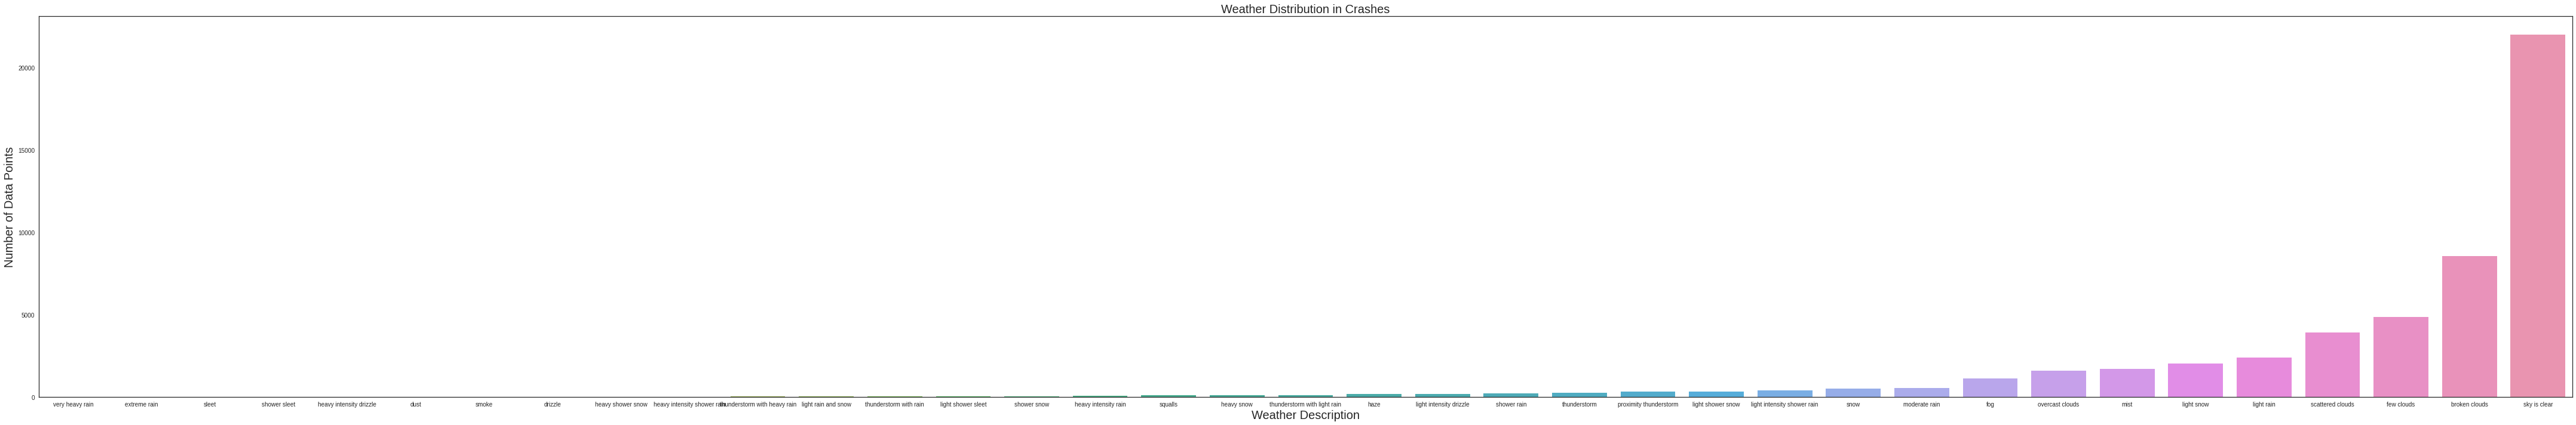

In [ ]:
EDAcrashweather1 = EDAcrashweather[EDAcrashweather['loc_01'] != 0 ]
weatherdist = EDAcrashweather1.groupby(EDAcrashweather1.weather_description).count()
weatherdist = weatherdist['temp'] 
weatherdist = weatherdist.reset_index()


plt.figure(figsize=(60,10))
axs = sns.barplot(x = 'weather_description', y = 'temp', data = weatherdist, order = weatherdist.sort_values('temp').weather_description)
plt.title("Weather Distribution in Crashes",fontsize=20)
plt.ylabel('Number of Data Points', fontsize=20)
plt.xlabel('Weather Description', fontsize=20)

plt.tight_layout()


##### Weather Distribution of No Accidents 

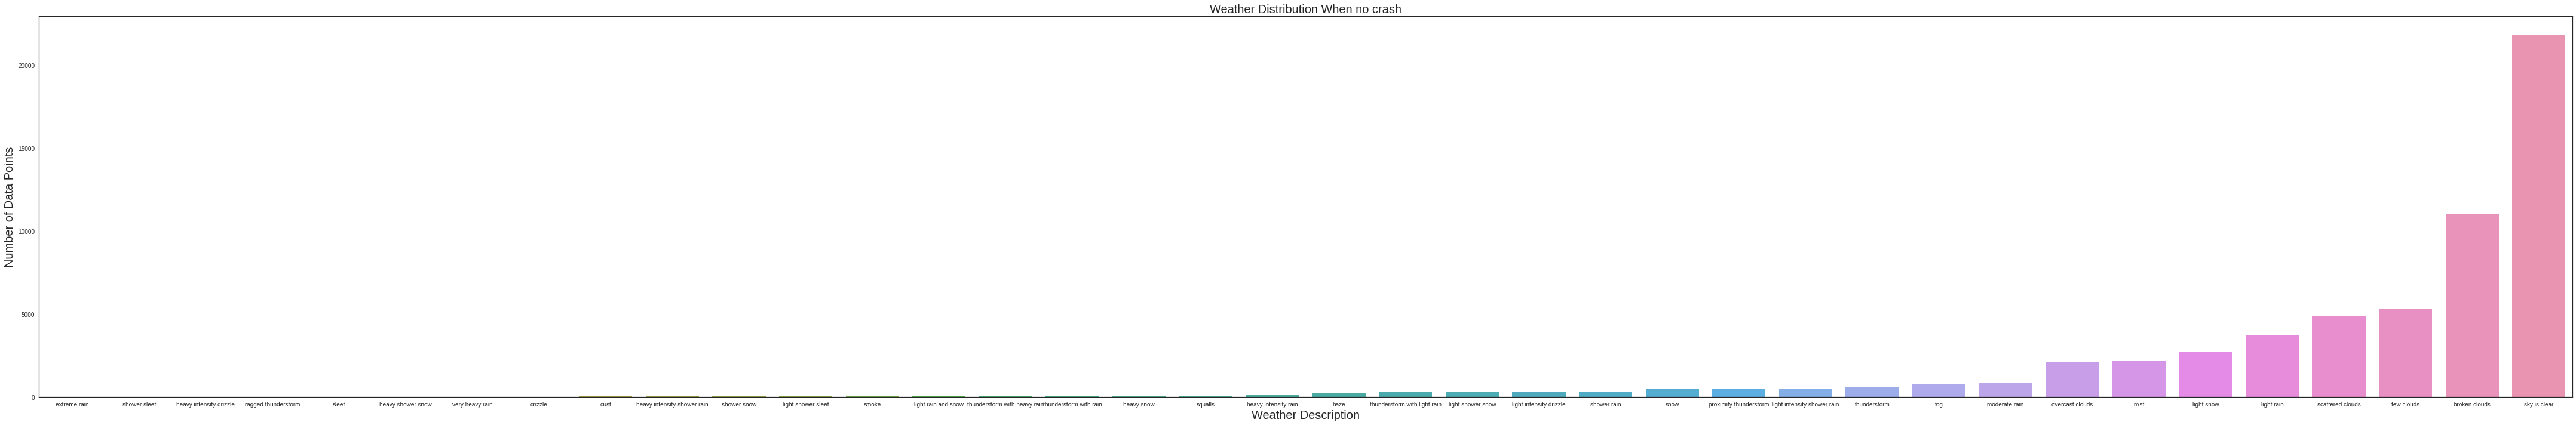

In [ ]:
EDAcrashweather1 = EDAcrashweather[EDAcrashweather['loc_01'] == 0 ]
weatherdist = EDAcrashweather1.groupby(EDAcrashweather1.weather_description).count()
weatherdist = weatherdist['temp'] 
weatherdist = weatherdist.reset_index()


plt.figure(figsize=(60,10))
axs = sns.barplot(x = 'weather_description', y = 'temp', data = weatherdist, order = weatherdist.sort_values('temp').weather_description)
plt.title("Weather Distribution When no crash",fontsize=20)
plt.ylabel('Number of Data Points', fontsize=20)
plt.xlabel('Weather Description', fontsize=20)

plt.tight_layout()

## Heatmaps


#### Heatmap- Crashes across a week

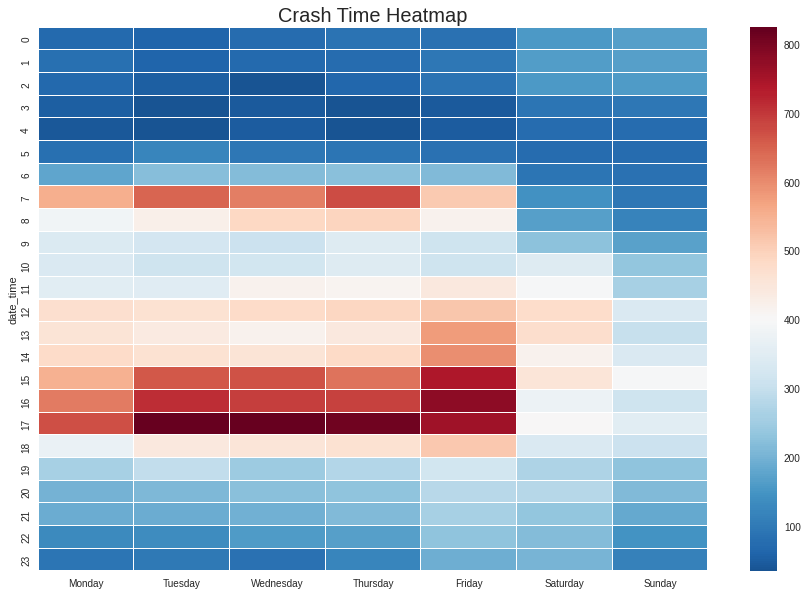

In [ ]:
table = pd.pivot_table(daily,index=[daily['date_time'].dt.hour],columns=['weekday'],values=['loc_01'],aggfunc=['count'],fill_value=0)


table.columns = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
table = table[order]

plt.figure(figsize=(15,10))
plt.title("Crash Time Heatmap",fontsize=20)
sns.heatmap(data=table, cmap="RdBu_r", linewidths=0.1, center = 400) 

#### Heatmap -  Crash and Weather Pearson Colinearity

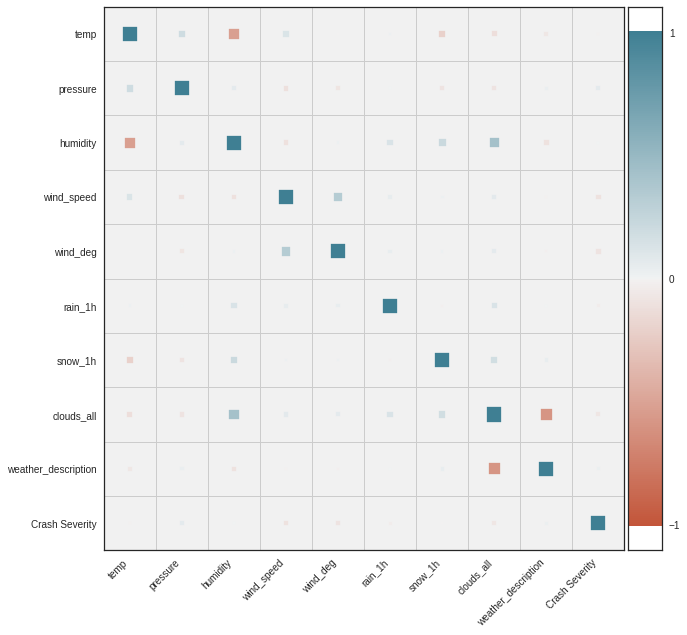

In [ ]:
!pip install heatmapz
from heatmap import heatmap, corrplot

data = crashweather
plt.figure(figsize=(10, 10))
corrplot(data.corr(), size_scale=200)

## Correlation - Weather and Crash

In [ ]:
EDAcrashweather

EDAcrashweather_corr = EDAcrashweather[['weather_description','loc_01']]

EDAcrashweather_corr.loc[EDAcrashweather_corr['loc_01'] != 0, 'Crash'] = 1
EDAcrashweather_corr.loc[EDAcrashweather_corr['loc_01'] == 0, 'No Crash'] = 1

df_pivot_weather = pd.pivot_table(EDAcrashweather_corr,index=['weather_description'], values=['Crash', 'No Crash'], aggfunc= ['sum'])
df_pivot_weather.columns = df_pivot_weather.columns.droplevel(0)
df_pivot_weather = df_pivot_weather.reset_index()

df_pivot_weather.set_index(["weather_description"], inplace=True)

df_pivot_weather = df_pivot_weather.div(df_pivot_weather.sum(axis=1), axis=0)
df_pivot_weather = df_pivot_weather.sort_values(by = 'Crash', ascending = False)

data = df_pivot_weather.copy()
data['No Crash'] = data['No Crash'].apply(lambda x: '%.0f%%' % (x*100))
data['Crash'] = data['Crash'].apply(lambda x: '%.0f%%' % (x*100))   

data

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Crash,No Crash
weather_description,,
shower snow,62%,38%
heavy shower snow,60%,40%
fog,59%,41%
heavy snow,58%,42%
squalls,56%,44%
light shower snow,55%,45%
light shower sleet,54%,46%
sky is clear,50%,50%
drizzle,50%,50%


# Train Test Split

In [ ]:
y = crashweather['Crash Severity']
X = crashweather.drop('Crash Severity', axis = 1)

#normalize data
scaler = StandardScaler()
x = scaler.fit_transform(X.values)
x = pd.DataFrame(x, index=X.index, columns=X.columns)


x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.3,
                                                    random_state=0)




## Accident Distribution in Train test split

Text(0.5, 0, 'Severity')

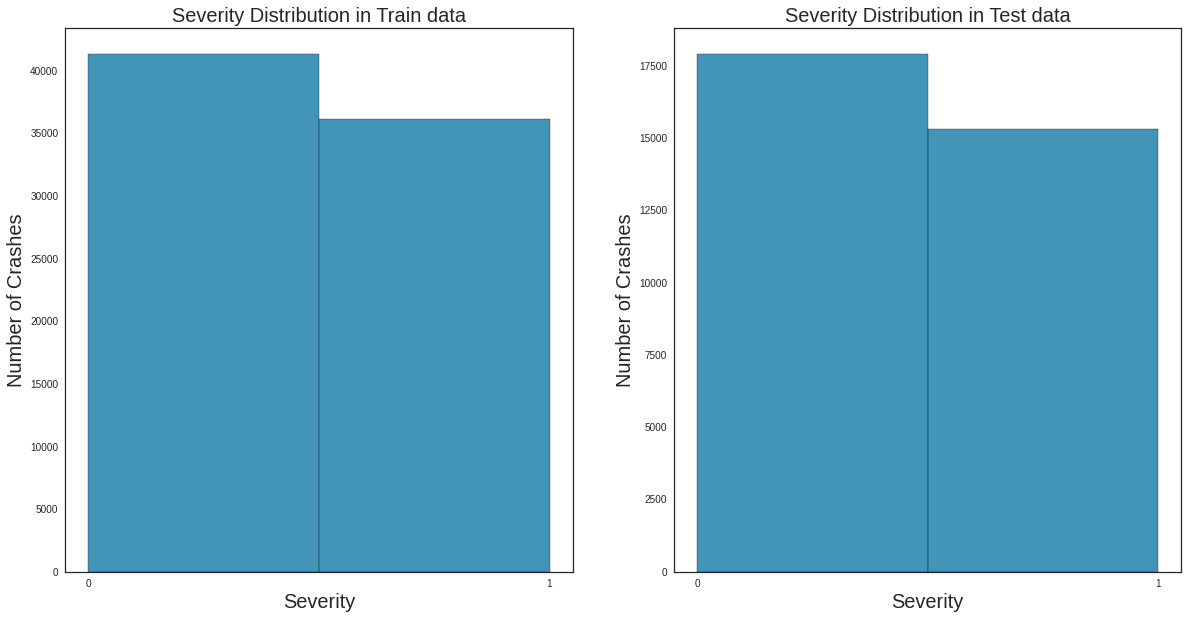

In [ ]:
f, axs = plt.subplots(2,2,figsize=(20,10))

plt.subplot(1,2,1)
sns.histplot(data = y_train, bins = 2)
plt.xticks([0,1])
plt.title("Severity Distribution in Train data",fontsize=20)
plt.ylabel('Number of Crashes', fontsize=20)
plt.xlabel('Severity', fontsize=20)

plt.subplot(1,2,2)
sns.histplot(data = y_test, bins = 2)
plt.xticks([0,1])
plt.title("Severity Distribution in Test data",fontsize=20)
plt.ylabel('Number of Crashes', fontsize=20)
plt.xlabel('Severity', fontsize=20)

# Model Selection

In [ ]:
# DecisionTree Model
DT = DecisionTreeClassifier()
DT.fit(x_train,y_train)

# RandomForest Model
RF = RandomForestClassifier()
RF.fit(x_train,y_train)

# XGBoost Model 
XGB = XGBClassifier()
XGB.fit(x_train,y_train)

# KNeighbors Model
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

### lgbm
lgbm = lgb.LGBMClassifier()
lgbm.fit(x_train, y_train)

###logit Regression
logreg = LogisticRegression( max_iter=100000, random_state=0)
logreg.fit(x_train, y_train)

models = [DT, knn, RF,XGB, lgbm, logreg]

names = ['DT', "knn", "RF", "XGB", "lgbm",'logit']
evaluates = ['accuracy','precision','recall','f1','auc']

df_list = []
for name, model in zip(names, models):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # accuracy
    train_accuracy = model.score(x_train, y_train)
    test_accuracy = model.score(x_test, y_test)
    # precision
    train_precision = precision_score(y_train, y_train_pred, average = 'weighted')
    test_precision = precision_score(y_test, y_test_pred, average = 'weighted')
    # recall
    train_recall = recall_score(y_train, y_train_pred, average = 'weighted')
    test_recall = recall_score(y_test, y_test_pred, average = 'weighted')
    # f1
    train_f1 = f1_score(y_train, y_train_pred, average = 'weighted')
    test_f1 = f1_score(y_test, y_test_pred, average = 'weighted')


    train_auc = roc_auc_score(y_train, y_train_pred, multi_class = 'ovr')
    test_auc = roc_auc_score(y_test, y_test_pred, multi_class = 'ovr')
    print('{}  Train Data： accuracy:{:.3}, precision:{:.3}, recall:{:.3}, f1:{:.3}, auc:{:.3}'.format(name, train_accuracy,
                                                                                              train_precision,
                                                                                              train_recall, train_f1,
                                                                                              train_auc))
    print('{}  Test Data： accuracy:{:.3}, precision:{:.3}, recall:{:.3}, f1:{:.3}, auc:{:.3}'.format(name, test_accuracy,
                                                                                              test_precision,
                                                                                              test_recall, test_f1,
                                                                                              test_auc))
    print('\n')
    df = pd.DataFrame(np.array(
        [train_accuracy, train_precision, train_recall, train_f1, train_auc, test_accuracy, test_precision, test_recall,
         test_f1, test_auc]).reshape(2, -1),
                      index=['train', 'test'],
                      columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-Score'])
    df_list.append(df)

result = pd.concat(df_list, axis=0, keys=names)
result[:]

DT  Train Data： accuracy:0.901, precision:0.905, recall:0.901, f1:0.901, auc:0.897
DT  Test Data： accuracy:0.716, precision:0.716, recall:0.716, f1:0.716, auc:0.714


knn  Train Data： accuracy:0.779, precision:0.78, recall:0.779, f1:0.779, auc:0.779
knn  Test Data： accuracy:0.658, precision:0.66, recall:0.658, f1:0.659, auc:0.658


RF  Train Data： accuracy:0.901, precision:0.902, recall:0.901, f1:0.902, auc:0.902
RF  Test Data： accuracy:0.744, precision:0.745, recall:0.744, f1:0.744, auc:0.743


XGB  Train Data： accuracy:0.631, precision:0.63, recall:0.631, f1:0.629, auc:0.627
XGB  Test Data： accuracy:0.626, precision:0.625, recall:0.626, f1:0.625, auc:0.621


lgbm  Train Data： accuracy:0.674, precision:0.676, recall:0.674, f1:0.675, auc:0.675
lgbm  Test Data： accuracy:0.652, precision:0.655, recall:0.652, f1:0.653, auc:0.653


logit  Train Data： accuracy:0.572, precision:0.57, recall:0.572, f1:0.559, auc:0.561
logit  Test Data： accuracy:0.573, precision:0.568, recall:0.573, f1:0.56, a

Accuracy  Precision    Recall  F1-Score  AUC-Score
DT    train  0.901451   0.905406  0.901451  0.900814   0.897453
      test   0.715761   0.715829  0.715761  0.715794   0.714137
knn   train  0.779077   0.779940  0.779077  0.779268   0.779268
      test   0.658034   0.660041  0.658034  0.658515   0.658153
RF    train  0.901451   0.901823  0.901451  0.901514   0.901792
      test   0.744158   0.744583  0.744158  0.744314   0.743278
XGB   train  0.631163   0.629988  0.631163  0.629355   0.626584
      test   0.626144   0.624713  0.626144  0.624699   0.621184
lgbm  train  0.674423   0.676172  0.674423  0.674775   0.674834
      test   0.652283   0.655142  0.652283  0.652811   0.653073
logit train  0.572260   0.569700  0.572260  0.558841   0.560776
      test   0.572633   0.568397  0.572633  0.560361   0.559720

# Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(random_state=0)
clf.fit(x_train, y_train)
print(classification_report(y_test, clf.predict(x_test)))

cv_scores = cross_val_score(clf, x_train, y_train, cv=10)
print("Accuracy of %0.2f, with a standard deviation of %0.2f" % (cv_scores.mean(), cv_scores.std()))

              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76     17899
         1.0       0.72      0.73      0.72     15309

    accuracy                           0.74     33208
   macro avg       0.74      0.74      0.74     33208
weighted avg       0.74      0.74      0.74     33208

Accuracy of 0.73, with a standard deviation of 0.01


## Confusion Matrix

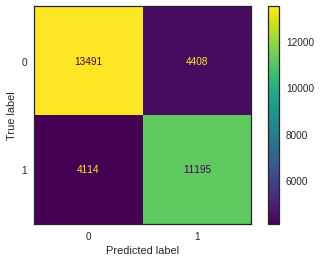

In [ ]:
y_pred = clf.predict(x_test)

cm_crash = confusion_matrix(y_test,y_pred)
display_cm_crash = ConfusionMatrixDisplay(confusion_matrix=cm_crash)
display_cm_crash.plot()

## Feature Importance

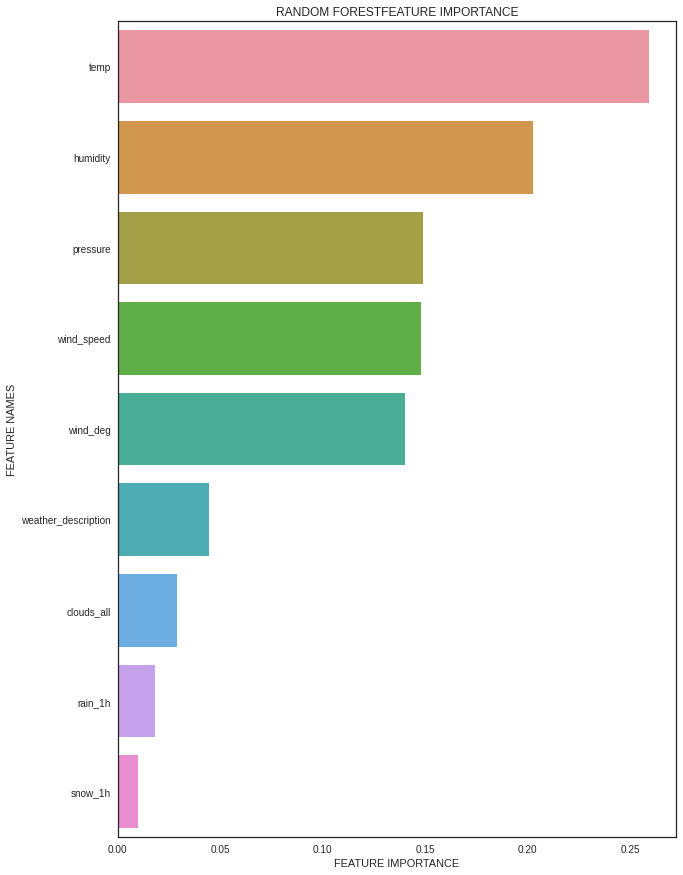

In [ ]:
def plot_feature_importance(importance,names,model_type):
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,15))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance(clf.feature_importances_,x.columns,'RANDOM FOREST')

# Log Reg

## Variable Coefficients 

In [ ]:
logreg = LogisticRegression( max_iter=100000, random_state=0)
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

print("Training set score: {:.3f}".format(logreg.score(x_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(x_test,y_test)))

coef_list = logreg.coef_.tolist()[0]
feature_names = list(x.columns)
coefdf = pd.DataFrame({'feature_names':feature_names, 'coef':coef_list})
print(coefdf)

Training set score: 0.572
Test set score: 0.573
         feature_names      coef
0                 temp -0.001210
1             pressure  0.113287
2             humidity  0.059474
3           wind_speed -0.121231
4             wind_deg -0.120453
5              rain_1h -0.064249
6              snow_1h  0.022658
7           clouds_all -0.158495
8  weather_description -0.035954


## Log Reg Confusion Matrix


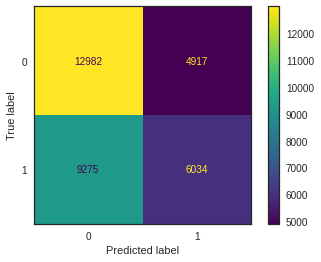

In [ ]:
cm_crash = confusion_matrix(y_test,y_pred)
display_cm_crash = ConfusionMatrixDisplay(confusion_matrix=cm_crash)
display_cm_crash.plot()